<a href="https://www.kaggle.com/aleksandrdubrovin/model-classification-training-snr-high?scriptVersionId=88379757" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import libraries

In [1]:
import os
import sys
import keras
import zipfile
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from mlflow.models.signature import infer_signature
%matplotlib inline

2022-03-21 00:14:59.405922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2022-03-21 00:14:59.405986: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://hb.bizmrg.com"
#REPLACE VALUE OF TRACKING URI WITH YOUR OWN
os.environ["MLFLOW_TRACKING_URI"] = "http://10.0.1.8:8000"
!echo $MLFLOW_S3_ENDPOINT_URL
!echo $MLFLOW_TRACKING_URI

https://hb.bizmrg.com
http://10.0.1.8:8000


## Getting and Loading the Data

In [3]:
general_path = 'data'
# Upload signals, labels, snrs
labels = np.load(f'{general_path}/labels.npy', mmap_mode = 'r')
snrs = np.load(f'{general_path}/snrs.npy', mmap_mode = 'r')
signals = np.load(f'{general_path}/signals.npy', mmap_mode = 'r')

# Open classes.txt
with open(f'{general_path}/classes.txt') as file: 

   classes = file.read()

def str_to_list(line):
    line = line.replace('\n','')
    line = line.replace('classes = ','')
    line = eval(line)
    return line
    
classes = str_to_list(classes)

In [4]:
# Split arrays for two 3 parts (we take only third part of dataset of labeled signals because of the memory)
part = 6
signals = signals[::part, :, :]
labels = labels[::part, :]
snrs = snrs[::part, :]

print(signals.shape)
print(labels.shape)
print(snrs.shape)

# Ndarray to array
snrs = np.ravel(snrs)
print(f"All possible SNRS: {np.unique(snrs)} db")

# Masked numpy array 
c = np.ma.masked_where(snrs > 8, snrs)
msk = c.mask
# Count unique elements in array
print(f'Quantity unique elements in array is {np.unique(c.mask, return_counts=True)}')

# Mask array of signals and labels (snrs > 8)
signals = signals[msk]
labels = labels[msk]

print(f'Quantity of signals is {len(signals)}')

(425984, 1024, 2)
(425984, 24)
(425984, 1)
All possible SNRS: [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.] db
Quantity unique elements in array is (array([False,  True]), array([245760, 180224]))
Quantity of signals is 180224


In [5]:
# Train|test = 80|20

x_train,x_test, y_train, y_test = train_test_split(signals, labels, train_size=0.8, stratify=labels)

# print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
# print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")
print(x_test.shape)
print(y_test.shape)

# Train|validation|test = 64|16|20
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, stratify=y_train)

# print(f"Количество строк в y_train по классам: {np.bincount(y_test)}")
# print(f"Количество строк в y_test по классам: {np.bincount(y_val)}")
print(x_train.shape)
print(y_train.shape)

(36045, 1024, 2)
(36045, 24)
(115343, 1024, 2)
(115343, 24)


## Create Residual Stack

In [6]:
# Create residual and convolution blok
class Residual_block:
    kernel_size = 3
    strides = 1
    padding = 'same'
    data_format = "channels_last"

    def __init__(self, x, x_shortcut, filters):
        self.x = x
        self.filters = filters
        self.x_shortcut = x_shortcut

    def unit(self):
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(self.x)
        x = Activation('relu')(x)
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(x)
        x = Activation('linear')(x)
        # add skip connection
        if x.shape[1:] == self.x_shortcut.shape[1:]:
            x = Add()([x, self.x_shortcut])
        else:
            raise Exception('Skip Connection Failure!')
        return x

class Convolution_block:
    kernel_size = 1
    strides = 1
    padding = 'same'
    data_format = "channels_last"

    def __init__(self, x, filters):
        self.x = x
        self.filters = filters

    def unit(self):
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(self.x)
        x = Activation('linear')(x)
        return x
    
# Create residual stack
def residual_stack(x, filters):
    x = Convolution_block(x, filters)
    x = x.unit()
    
    x_shortcut = x
    x = Residual_block(x, x_shortcut, filters)
    x = x.unit()
    x_shortcut = x
    x = Residual_block(x, x_shortcut, filters)  
    x = x.unit()
    
    # max pooling layer
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
#     print('Residual stack created')
    return x

## Define ResNet Model

In [7]:
# define resnet model
def ResNet(input_shape, classes):   
    # create input tensor
    x_input = Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 40
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    
    # output layer
    x = Flatten()(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes , activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    
    # Create model
    model = Model(inputs = x_input, outputs = x)
#     print('Model ResNet created')
    return model

## Option to Save Model Weights and History

In [8]:
# option to save model weights and model history
save_model = False
save_history = False

# create directory for model weights
if save_model is True:
    weights_path = input("Name model weights directory: ")
    weights_path = "data/weights/" + weights_path

    try:
        os.mkdir(weights_path)
    except OSError:
        print ("Creation of the directory %s failed" % weights_path)
    else:
        print ("Successfully created the directory %s " % weights_path)
    print('\n')
    

# create directory for model history
if save_history is True:
    history_path = input("Name model history directory: ")
    history_path = "data/model_history/" + history_path

    try:
        os.mkdir(history_path)
    except OSError:
        print ("Creation of the directory %s failed" % history_path)
    else:
        print ("Successfully created the directory %s " % history_path)
    print('\n')

## Set Model Parameters

In [9]:

# initialize optimizer 
adm = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# set number of epochs
# num_epochs = int(input('Enter number of epochs: '))
num_epochs = 5
# set batch size
batch = 32

# configure weights save

if save_model is True:
    filepath= weights_path + "/{epoch}.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode="auto")
    callbacks_list = [checkpoint]
else:
    callbacks_list = []



## Print Model Summary and Train Network

2022-03-21 00:16:31.143556: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-21 00:16:31.143750: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mlflow-ml): /proc/driver/nvidia/version does not exist
2022-03-21 00:16:31.145138: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 2)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 40)     120         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 1024, 40)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1024, 40)     4840        ['activation[0][0]']             
                                                                                              

                                                                                                  
 add_5 (Add)                    (None, 256, 40)      0           ['activation_14[0][0]',          
                                                                  'add_4[0][0]']                  
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 128, 40)     0           ['add_5[0][0]']                  
                                                                                                  
 conv1d_15 (Conv1D)             (None, 128, 40)      1640        ['max_pooling1d_2[0][0]']        
                                                                                                  
 activation_15 (Activation)     (None, 128, 40)      0           ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_16

2022-03-21 00:16:32.139380: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 944889856 exceeds 10% of free system memory.


Epoch 1/5
3605/3605 [==============================] - ETA: 0s - loss: 2.4815 - accuracy: 0.2626

2022-03-21 00:24:38.831819: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 236224512 exceeds 10% of free system memory.


3605/3605 [==============================] - 513s 142ms/step - loss: 2.4815 - accuracy: 0.2626 - val_loss: 1.3948 - val_accuracy: 0.4562
Epoch 2/5
3605/3605 [==============================] - 476s 132ms/step - loss: 1.4201 - accuracy: 0.4567 - val_loss: 1.1124 - val_accuracy: 0.5400
Epoch 3/5
3605/3605 [==============================] - 489s 136ms/step - loss: 1.1580 - accuracy: 0.5313 - val_loss: 0.9546 - val_accuracy: 0.5934
Epoch 4/5
3605/3605 [==============================] - 506s 140ms/step - loss: 1.0028 - accuracy: 0.5767 - val_loss: 0.8336 - val_accuracy: 0.6370
Epoch 5/5
3605/3605 [==============================] - 510s 141ms/step - loss: 0.8383 - accuracy: 0.6335 - val_loss: 0.6953 - val_accuracy: 0.6864


2022-03-21 00:58:10.883708: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpoo29rbx9/model/data/model/assets


2022-03-21 00:58:25.714605: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 295280640 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: /tmp/tmpdksziyq4/model/data/model/assets


2022-03-21 00:59:16.777593: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 295280640 exceeds 10% of free system memory.


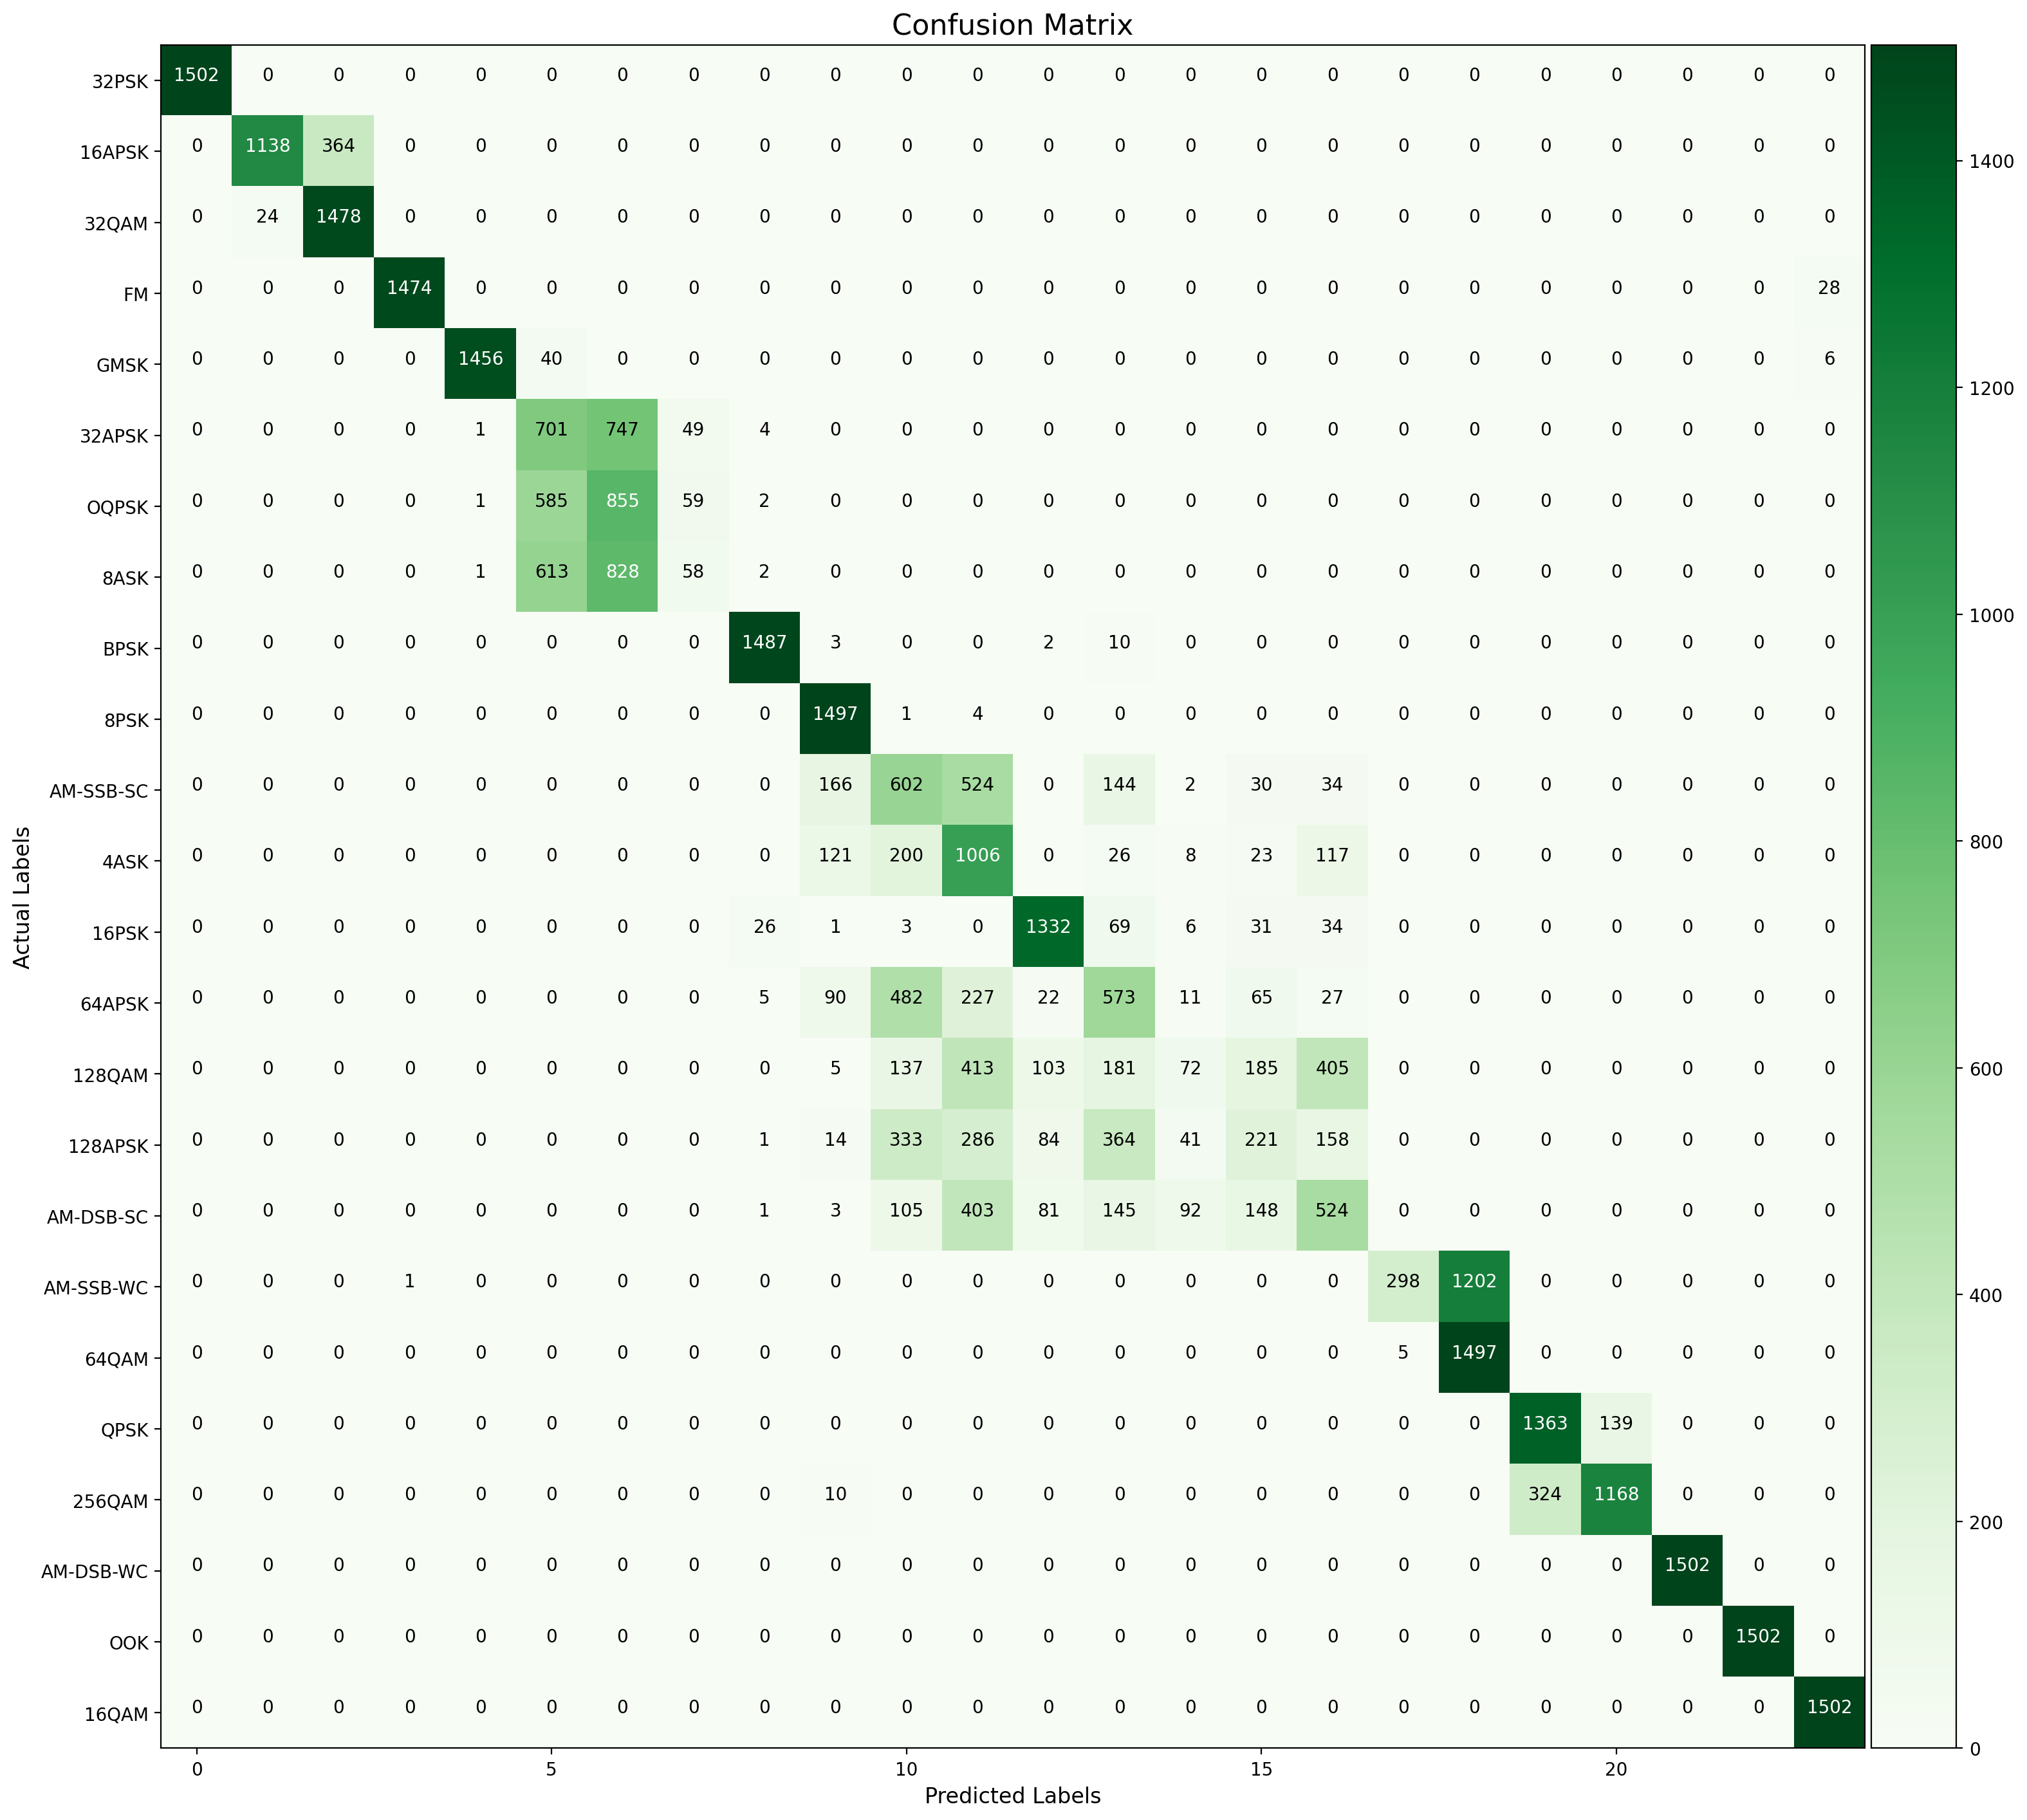

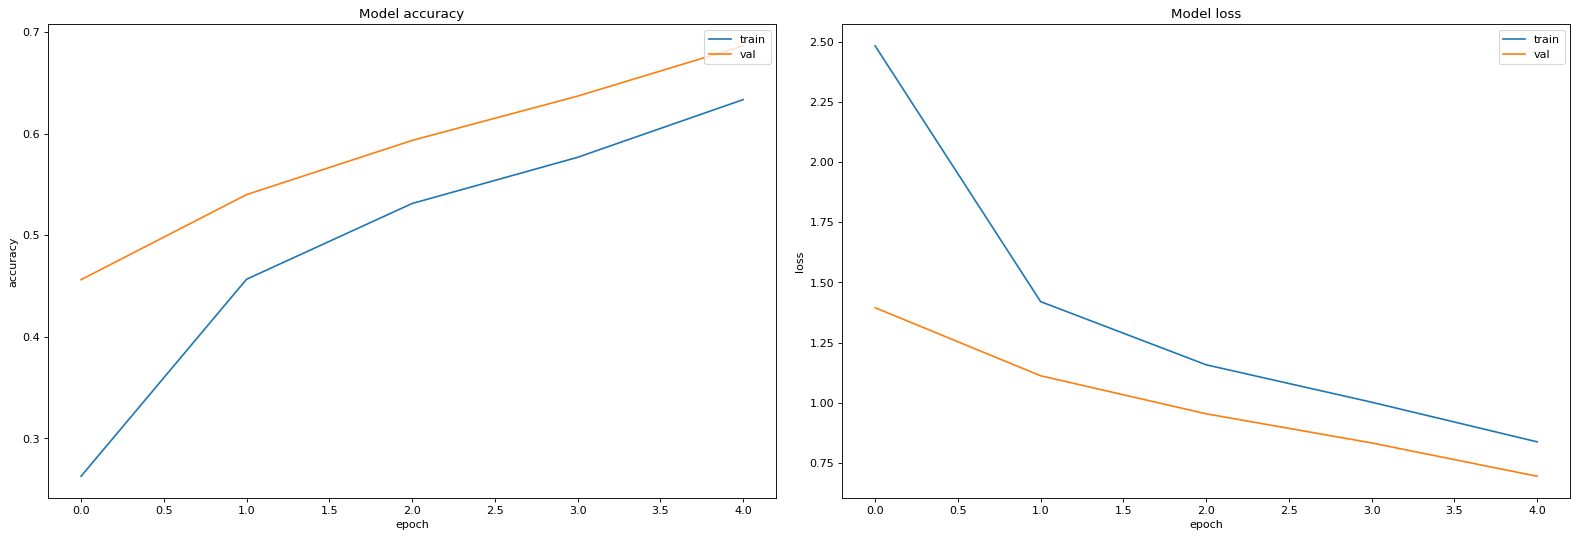

In [10]:
# Import mlflow
import mlflow
import mlflow.keras
import mlflow.tensorflow

if __name__ == "__main__":
    mlflow.set_experiment("Auto_logging")
    # autolog your metrics, parameters, and model
    mlflow.tensorflow.autolog()
    mlflow.start_run()
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # initialize and train model
    model = ResNet((1024, 2), 24)
    model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    history = model.fit(x_train, y_train, epochs = num_epochs, batch_size = batch, callbacks=callbacks_list, validation_data=(x_val, y_val))   
    
    # Create an input example, signature to store in the MLflow model registry
    signature = infer_signature(x_test, model.predict(x_test))
    model_name = 'signal classifier'
    input_example = np.expand_dims(x_test[0], axis=0)
    input_example=input_example    
    mlflow.keras.log_model(model, model_name, signature=signature, input_example=input_example)
    
    # Confusion Matrix
    predictions=model.predict(x_test)
    classes_y=np.argmax(predictions,axis=1)
    conf_matrix = confusion_matrix(y_true=np.argmax(y_test,axis=1), y_pred=classes_y)
    
    nr_rows = conf_matrix.shape[0]
    nr_cols = conf_matrix.shape[1]

    fig = plt.figure(figsize=(18,18), dpi= 200) 
    im = plt.imshow(conf_matrix, cmap=plt.cm.Greens)
    ax = plt.gca()
    plt.title('Confusion Matrix', fontsize=16) 
    plt.ylabel('Actual Labels', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)
    tick_marks = np.arange(len(classes))
    plt.yticks(tick_marks, classes)
    # plt.xticks(tick_marks, classes)

    for i, j in itertools.product(range(nr_rows), range(nr_cols)):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
                color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

    # Divide existing axes and create new axes at bottom side of image
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax) 
    
    
    
    
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    history = [[train_acc, val_acc],[train_loss, val_loss]]
    title = ['Model accuracy', 'Model loss']
    ylabel = ['accuracy', 'loss']
    fig1 = plt.figure(figsize=(20, 7), dpi=80)
    for i, id in enumerate(title):
        plt.subplot(1, 2, i+1)

        plt.plot(history[i][0], label = 'train')
        plt.plot(history[i][1], label = 'val')
        plt.title(id)
        plt.xlabel('epoch')
        plt.ylabel(ylabel[i])
        plt.legend(loc='upper right')
    plt.tight_layout(pad=1.7)
    
    #Save figures
    fig.savefig("Confusion matrix.png")
    fig1.savefig("Accuracy and loss.png")

#     # Close plot
#     plt.close(fig)

    # Log artifacts (output files)
    mlflow.log_artifact("Confusion matrix.png")
    mlflow.log_artifact("Accuracy and loss.png")
    
    mlflow.end_run()

## Evaluate Model on Test Data

In [11]:
loss, acc = model.evaluate(x_test, y_test, batch_size=32)
print('EVALUATING MODEL ON TEST DATA:')
print('Test Accuracy: ', str(round(acc*100, 2)), '%')
print('\n')

   1/1127 [..............................] - ETA: 1:29 - loss: 0.5058 - accuracy: 0.7812

2022-03-21 00:59:59.830987: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 295280640 exceeds 10% of free system memory.


1127/1127 [==============================] - 39s 34ms/step - loss: 0.6923 - accuracy: 0.6883
EVALUATING MODEL ON TEST DATA:
Test Accuracy:  68.83 %




## Mis-classified example

Below is an example of a signal that was mis-classified by the model (AM-SSB-WC signal was mis-classified as a 64QAM signal)

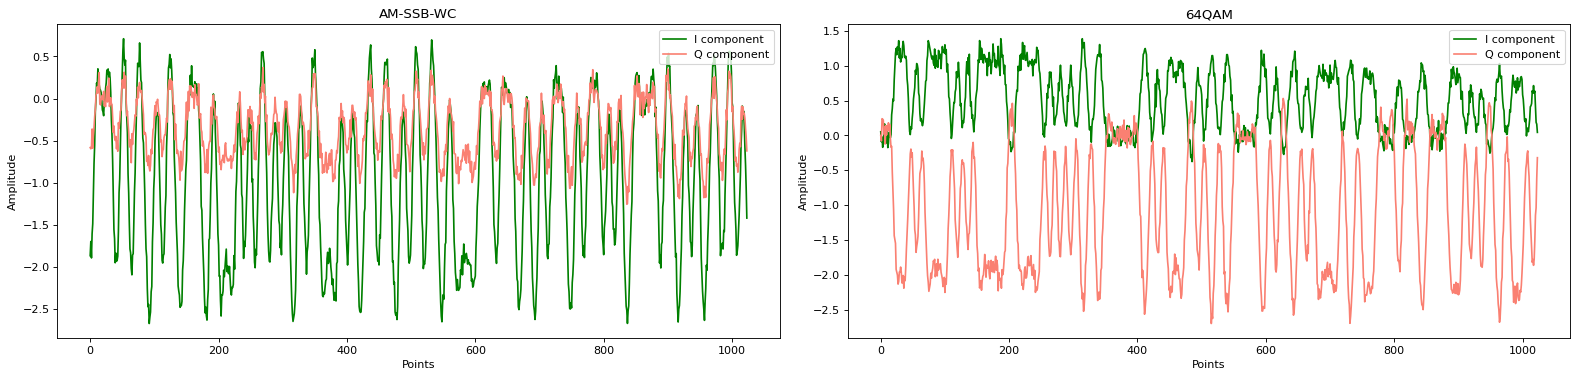

In [12]:
idx = [17,18]
fig = plt.figure(figsize=(20, 5), dpi=80)
for i, id in enumerate(idx):
    plt.subplot(1, 2, i+1)
    plt.plot(signals[id][:, 0], color='green', label='I component')
    plt.plot(signals[id][:, 1], color='salmon', label='Q component')
    plt.title(classes[id])
    plt.xlabel('Points')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
plt.tight_layout(pad=1.7)

## Save model history

In [13]:
# record model history

if save_history is True:
    # save model history: loss and accuracy
    np.save(history_path + '/train_acc.npy', train_acc)
    np.save(history_path + '/train_loss.npy', train_loss)
    np.save(history_path + '/val_acc.npy', val_acc)
    np.save(history_path + '/val_loss.npy', val_loss)
    print("Model History Saved!")
    print('\n')